<a href="https://colab.research.google.com/github/farheentrisha/CNN-based-image-classification/blob/main/advanced_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
train_images = train_images/255.0
test_images= test_images/255.0

In [5]:
class_name=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
def build_model(hp):
    model = models.Sequential()

    # Convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        if i == 0:
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', 32, 128, step=16),
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(32, 32, 3)
            ))
        else:
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', 32, 128, step=16),
                kernel_size=(3, 3),
                activation='relu',
                padding='same'
            ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', 32, 128, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(
            rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        ))

    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,  # ✅ corrected here
    directory='my_dir',
    project_name='cifar10_tuning'
)

tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Trial 10 Complete [00h 15m 16s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.6955999732017517
Total elapsed time: 02h 10m 41s
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 197s 124ms/step - accuracy: 0.3349 - loss: 1.7805 - val_accuracy: 0.5940 - val_loss: 1.1570
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 206s 127ms/step - accuracy: 0.5836 - loss: 1.1836 - val_accuracy: 0.6469 - val_loss: 1.0102
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 205s 129ms/step - accuracy: 0.6591 - loss: 0.9890 - val_accuracy: 0.6715 - val_loss: 0.9431
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 195s 125ms/step - accuracy: 0.7016 - loss: 0.8764 - val_accuracy: 0.6725 - val_loss: 0.9615
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 194s 124ms/step - accuracy: 0.7293 - loss: 0.7929 - val_accuracy: 0.6951 - val_loss: 0.8747
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 124ms/step - accuracy: 0.7573 - loss: 0.7090 - val_accuracy: 0.6879 - val_loss: 0.9247
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 208s 128ms

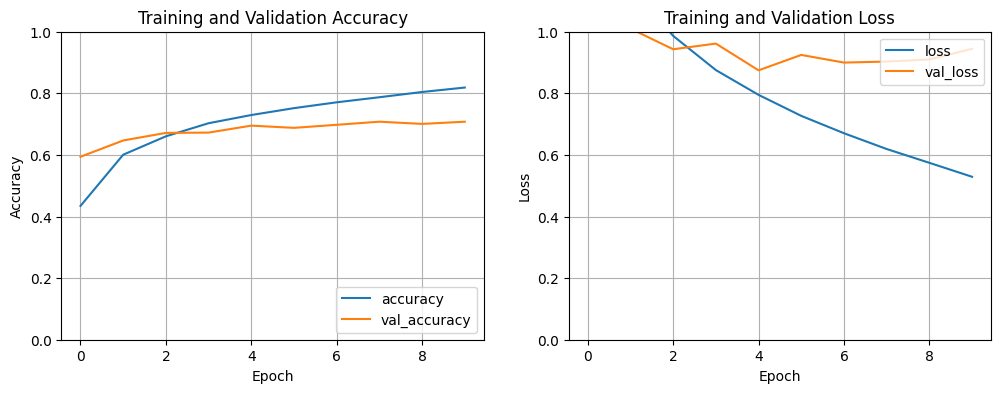

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()